In [2]:
import numpy as np
import open3d as o3d
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits import mplot3d
import os
import itertools
import seaborn as sns


In [150]:
working_directory = os.getcwd()
# working_directory = '/Users/gabrielbar-sella/Documents/studies/research_project/3D_Corn_Phenotype'
pcd_data_dir = "samples/round_2/28.2.23"
root_dir = os.path.join(working_directory, pcd_data_dir)
alpha = 0.06

# working_directory

In [153]:
### leaves area measurements csv, taken on 28.2.23

measured_data_path = os.path.join(working_directory, 'leaf_area.csv')
measured_data = pd.read_csv(measured_data_path)
measured_data['organ_type'] = 'leaf'

### multiplying leaf area to get both the abaxial and adaxial areas as the code for the surface area calculation
### includes both of them 
measured_data['area'] = measured_data['area'] * 2

### grouping the data to get leaves count for each plant
leaves_cnt = measured_data.groupby(['plant_num','organ_type'])['leaf_num'].nunique().reset_index(name='leaves_cnt')

### grouping the data to get the averaged leaf area for each leaf 
leaves_avg_area = measured_data.groupby(['plant_num', 'leaf_num','organ_type'], as_index=False) .agg({'area':['mean','std']})

leaves_avg_area.columns = ['plant_num', 'leaf_num', 'organ_type','measured_area', 'measured_area_std']


In [9]:
def extract_surface_area_methods(pcd, reconstruction_method,organ_type, **kwargs):
    ### function for triangular surface reconstruction and area calculation for
    ### a given point cloud and a reconstruction method. 
    ### After testing all of them, in the project I used only AlphaShapes reconstruction method.

    if reconstruction_method == 'Poisson':
        print("Reconstructing surface using Poisson algorithm...")
        mesh, _ = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, **kwargs)
    elif reconstruction_method == 'BallPivoting':
        print("Reconstructing surface using Ball-Pivoting algorithm...")

        mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd, **kwargs)
    elif reconstruction_method == 'AlphaShapes':
        print("Reconstructing surface using Alpha Shapes algorithm...")
        mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd,  **kwargs)


    ### extractin triangle and vertices from the reconstructed mesh object
    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)


    ### calculating the surface area
    surface_area = 0
    for i in range(triangles.shape[0]):
        ### getting the vertices of the i-th triangle
        v1, v2, v3 = vertices[triangles[i, :]]
        # Compute the side lengths of the triangle
        a = np.linalg.norm(v1 - v2)
        b = np.linalg.norm(v2 - v3)
        c = np.linalg.norm(v3 - v1)
        ### using Heron's formula to compute the area of each triangle
        s = (a + b + c) / 2
        surface_area += np.sqrt(s * (s - a) * (s - b) * (s - c))
        ### visualise the mesh
#     o3d.visualization.draw_geometries([pcd, mesh])


    ### returning the whole surface are if the organ is 'stem' or 'whole_plant' and half of it if it  
    ### is 'leaf'. Eventually decided to multiply the measured area by 2 instead of deviding the calculated one by 2
    if organ_type == 'stem' or organ_type == 'whole_plant':
        return round(surface_area*10000,3)
    elif organ_type == 'leaf':
#         return round((surface_area/2)*10000,3)
        return round(surface_area*10000,3)


In [10]:
def load_pcd(path):
    ### loads a '.txt' point cloud and extracts the points (first 3 columns) and the 
    ### labels (last 3 columns) into separate arrays.

    
    plant_pcd = np.loadtxt(path,delimiter=' ')
    if plant_pcd.shape[1] == 3:
        points = plant_pcd[:, :3]
        return points
    else:
        points = plant_pcd[:, :3]
        labels = plant_pcd[:, 3]
        return points, labels   

In [12]:
def calculate_area_for_each_organ(pant_num, points, labels, radius=None):
    ### gets points and labels arrays.
    ### each label represetns a diiferent leaf, the higher the label the higher the leaf located on the plant
    ### for each label, the point cloud points are filtered and the surface area (squared cm) is calculad for
    ### each leaf separately. 
    ### returns a list of dicts, each dict for each organ 
    
    leaves_data = []
    for label in np.unique(labels):
#         print(label)
        filtered_points = points[labels == label]
        organ_pcd = o3d.geometry.PointCloud()
        organ_pcd.points = o3d.utility.Vector3dVector(filtered_points)
    #     o3d.visualization.draw_geometries([organ_pcd])

        if label == 1:
            organ_type='stem'
            organ_num=int(label)
            surface_area = extract_surface_area_methods(organ_pcd, 'AlphaShapes', organ_type, alpha=alpha)
            print(f"organ_type - {organ_type}, organ_num - {organ_num}, surface_area = {surface_area}(squared cm)")
            data = {"plant_num": plant_num, 'organ_type': organ_type, "organ_num": organ_num, "calculated_area": surface_area}
            if radius is not None:
                data['radius'] = radius
            leaves_data.append(data)
        else:
            organ_type='leaf'
            organ_num=int(label-1)
            surface_area = extract_surface_area_methods(organ_pcd, 'AlphaShapes', organ_type, alpha=alpha)
            print(f"organ_type - {organ_type}, organ_num - {organ_num}, surface_area = {surface_area}(squared cm)")
            data = {"plant_num": plant_num, 'organ_type': organ_type, "organ_num": organ_num, "calculated_area": surface_area}
            if radius is not None:
                data['radius'] = radius
            leaves_data.append(data)
            
    return leaves_data


# 1) Labeled point clouds vs measured

In [34]:

### iterating through all the files in each subdirectory in '28.2.23', choosing only the labeled point clouds.
### each point cloud is loaded using load_pcd() and the points, labels and plant number are sent to 
### calculate_area_for_each_organ() for calculating the surface area. 
### data is stored in calculated_data list, each organ's data in a separated dict 

calculated_data = []
for subdir, dirs, files in os.walk(root_dir):
    for filename in files:
        if "labeled" not in filename: 
            pass
        else:
            pcd_file_path = os.path.join(subdir, filename)
#             print(pcd_file_path)
            plant_num = filename.split('_')[1]
            print(f"plant_num - {plant_num}")
            points, labels = load_pcd(pcd_file_path)
            leaves_data = calculate_area_for_each_organ(plant_num, points, labels)
            calculated_data.extend(leaves_data)
            print('\n')


### converting calculated_data into a dataframe, 
calculated_data = pd.DataFrame(calculated_data)

### adjusting column types to enable joining between the dataframes
leaves_avg_area = leaves_avg_area.astype({"plant_num": str, "leaf_num": str})
calculated_data = calculated_data.astype({"plant_num": str, "organ_num": str})

### joining the tables into data_merged table, containing measured and calculated surface area for each leaf.
data_merged = pd.merge(calculated_data, leaves_avg_area, how='left', left_on=['plant_num','organ_num','organ_type'], right_on=['plant_num','leaf_num','organ_type'])
data_merged.loc[data_merged['organ_type'] == 'stem', ['leaf_num','measured_area','measured_area_std']] = data_merged.loc[data_merged['organ_type'] == 'stem', ['leaf_num','measured_area','measured_area_std']].fillna(0)
data_merged.dropna(inplace=True)
# data_merged

plant_num - 18
Reconstructing surface using Alpha Shapes algorithm...
organ_type - stem, organ_num - 1, surface_area = 180.178(squared cm)
Reconstructing surface using Alpha Shapes algorithm...
organ_type - leaf, organ_num - 1, surface_area = 249.528(squared cm)
Reconstructing surface using Alpha Shapes algorithm...
organ_type - leaf, organ_num - 2, surface_area = 413.154(squared cm)
Reconstructing surface using Alpha Shapes algorithm...
organ_type - leaf, organ_num - 3, surface_area = 517.501(squared cm)
Reconstructing surface using Alpha Shapes algorithm...
organ_type - leaf, organ_num - 4, surface_area = 419.954(squared cm)
Reconstructing surface using Alpha Shapes algorithm...
organ_type - leaf, organ_num - 5, surface_area = 229.652(squared cm)
Reconstructing surface using Alpha Shapes algorithm...
organ_type - leaf, organ_num - 6, surface_area = 61.306(squared cm)


plant_num - 9
Reconstructing surface using Alpha Shapes algorithm...
organ_type - stem, organ_num - 1, surface_area 

organ_type - leaf, organ_num - 4, surface_area = 444.207(squared cm)
Reconstructing surface using Alpha Shapes algorithm...
organ_type - leaf, organ_num - 5, surface_area = 339.358(squared cm)
Reconstructing surface using Alpha Shapes algorithm...
organ_type - leaf, organ_num - 6, surface_area = 97.704(squared cm)


plant_num - 8
Reconstructing surface using Alpha Shapes algorithm...
organ_type - stem, organ_num - 1, surface_area = 218.019(squared cm)
Reconstructing surface using Alpha Shapes algorithm...
organ_type - leaf, organ_num - 1, surface_area = 160.072(squared cm)
Reconstructing surface using Alpha Shapes algorithm...
organ_type - leaf, organ_num - 2, surface_area = 371.422(squared cm)
Reconstructing surface using Alpha Shapes algorithm...
organ_type - leaf, organ_num - 3, surface_area = 649.568(squared cm)
Reconstructing surface using Alpha Shapes algorithm...
organ_type - leaf, organ_num - 4, surface_area = 444.207(squared cm)
Reconstructing surface using Alpha Shapes algori

In [13]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
#     print(data_merged.sort_values(by=['plant_num','leaf_num'], ascending=True))
#     print(data_merged[data_merged['leaf_num'] == '8'])
#     print(data_merged.sort_values(by=['calculated_area'], ascending=False))
    

    plant_num organ_type organ_num  calculated_area leaf_num  measured_area  \
55          1       stem         1          127.679        0       0.000000   
56          1       leaf         1          137.831        1     109.693333   
57          1       leaf         2          353.931        2     246.506667   
58          1       leaf         3          429.001        3     292.400000   
59          1       leaf         4          241.219        4     167.546667   
60          1       leaf         5           69.711        5      32.860000   
61         10       stem         1          218.019        0       0.000000   
62         10       leaf         1          160.072        1      98.260000   
63         10       leaf         2          371.422        2     214.726667   
64         10       leaf         3          649.568        3     324.486667   
65         10       leaf         4          444.207        4     473.406667   
66         10       leaf         5          339.358 

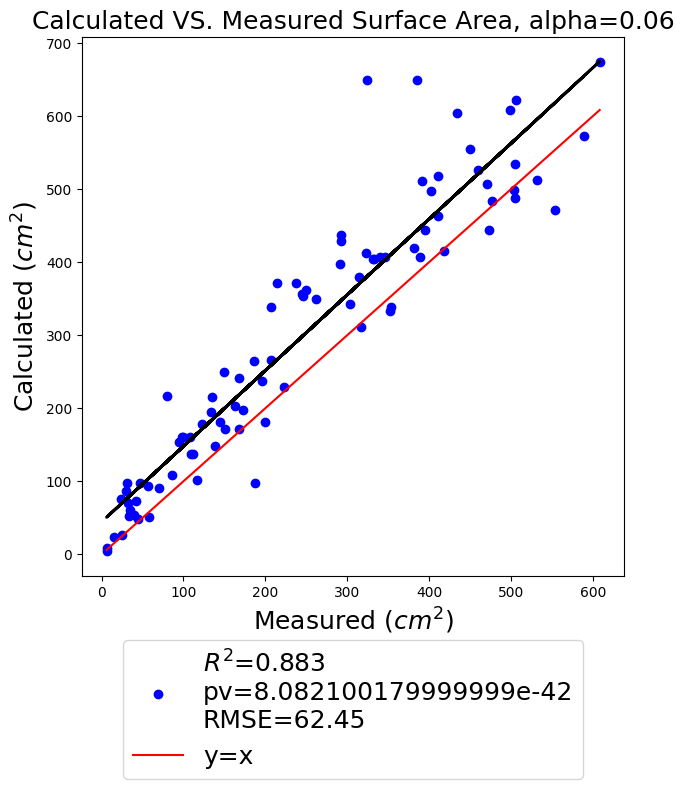

In [40]:
# SEED = 42
## removing plant no 13 due to incorrect measurements 
X = np.asarray(data_merged.loc[(data_merged['organ_type'] == 'leaf') & (data_merged['plant_num'] != '13'), 'measured_area'])
Y = np.asarray(data_merged.loc[(data_merged['organ_type'] == 'leaf') & (data_merged['plant_num'] != '13'), 'calculated_area'])


res = stats.pearsonr(X,Y)
r2 = round(res.statistic ** 2, 3)
pv = round(res.pvalue,50)

regr = LinearRegression().fit(X.reshape(-1, 1), Y.reshape(-1, 1))
y_pred = regr.predict(X.reshape(-1, 1))
rmse = mean_squared_error(Y, y_pred, squared=False)

coef_ = round(regr.coef_[0][0],3)
intercept_ = round(regr.intercept_[0],3)
eqaution = f"y = {coef_}X {intercept_}"

x_linear = np.linspace(X.min(),X.max(),100)
y_linear = x_linear


plt.figure(figsize=(7,7))

# plt.scatter(X, Y, color="blue", label=f'$R^2$={r2}\ncorr pv={pv}\nlinear eqaution: {eqaution}\nRMSE={rmse:.2f}')
plt.scatter(X, Y, color="blue", label=f'$R^2$={r2}\npv={pv}\nRMSE={rmse:.2f}')
plt.plot(x_linear, y_linear, '-r', label='y=x')#, linewidth=5)
plt.plot(X, y_pred, color="black", linewidth=2)
plt.title(f'Calculated VS. Measured Surface Area, alpha={alpha}', fontsize=18)
plt.xlabel('Measured ($cm^2$)', fontsize=18)
plt.ylabel(r'Calculated ($cm^2$)', fontsize=18)


plt.legend(fontsize=18, loc='lower center', bbox_to_anchor=(0.5, -0.4))
plt.show()




# 2) Data for labeled poinct cloud figure table - figure 3

In [50]:
### calculating all leaves measured\calculated area mean and std, according to their chronological number

leaves_avg_area = measured_data.groupby(['plant_num', 'leaf_num','organ_type'], as_index=False).agg({'area':['mean','std']})
leaves_avg_area.columns = ['plant_num', 'leaf_num', 'organ_type','measured_area', 'measured_area_std']


all_organs_agg = data_merged.groupby(['organ_type', 'organ_num'], as_index=False).agg({'calculated_area':['mean','std']
                                                                     ,'measured_area':['mean','std']}).round(3)#,'organ_num':['count']}).round(3)
all_organs_agg.columns = ['organ_type', 'organ_num', 'cross_calculated_mean' ,'cross_calculated_std', 'cross_measured_mean', 'cross_measured_std']

all_organs_cnt = data_merged.groupby(['organ_type', 'organ_num']).size().to_frame(name='N')

all_organs_agg = all_organs_agg.merge(all_organs_cnt, on=['organ_type', 'organ_num'])

### plant 6 figure data table
plant_6_data = data_merged[data_merged['plant_num']=='6'].drop(columns=['plant_num','leaf_num','measured_area_std']).round(3)

plant_6_figure = pd.merge(plant_6_data, all_organs_agg, how='inner', on=['organ_type', 'organ_num'])

plant_6_figure

,organ_type,organ_num,calculated_area,measured_area,cross_calculated_mean,cross_calculated_std,cross_measured_mean,cross_measured_std,N
0,stem,1,338.519,0.000,247.753,108.832,0.000,0.000,15
1,leaf,1,171.830,150.580,152.330,79.761,120.578,67.504,15
2,leaf,2,380.122,314.973,321.072,137.844,251.021,121.640,15
3,leaf,3,499.001,504.100,474.258,171.369,385.631,154.095,15
4,leaf,4,573.037,588.927,460.588,175.963,412.778,161.331,15
5,leaf,5,526.579,460.147,334.436,162.565,282.189,142.631,15
6,leaf,6,437.385,292.747,209.949,146.634,149.416,94.972,13
7,leaf,7,136.755,111.760,105.647,44.338,51.057,34.085,7


# 3) Predicting stem from total area, calculating canopy and comparing  to measured


In [69]:
### preparing the data for stem area vs total area correlation. 
### each plants' data is aggregated, resulting with a dataframe containing total leaf area, stem area, total area, 
### stem-leaves ratio and stem-total ratio.

summed = data_merged.groupby(['plant_num', 'organ_type'])['calculated_area'].sum().reset_index(name='summed_surface')
summed = pd.pivot_table(summed, values='summed_surface', index='plant_num', columns='organ_type').reset_index()
summed.columns = ['plant_num', 'leaf_summed_area', 'stem_summed_area']
summed['stem_leaf_ratio'] = summed['stem_summed_area'] / summed['leaf_summed_area']
summed['total_area'] = summed['stem_summed_area'] + summed['leaf_summed_area']
summed['stem_total_ratio'] = summed['stem_summed_area'] / summed['total_area']
cols = summed.columns.tolist()
cols = cols[:3] + cols[4:5] + cols[3:4] + cols[5:]
summed = summed[cols]
summed.sort_values(by=['plant_num'], ascending=True)
stem_of_total_ratio_factor = round(summed['stem_total_ratio'].mean(),6)


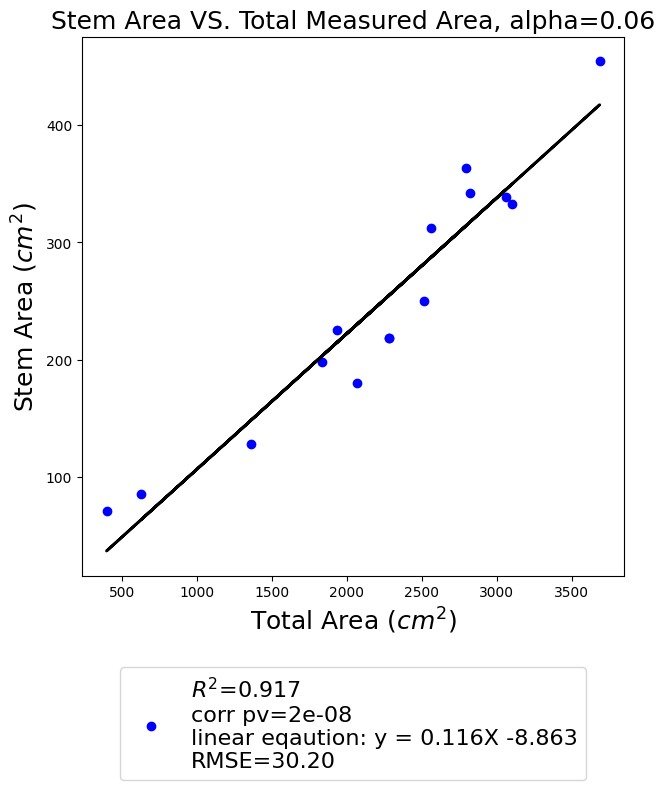

In [64]:
### running regression to get a linear equation to predict the stem area from a plant's total area


X = np.asarray(summed['total_area'])
Y = np.asarray(summed['stem_summed_area'])

res = stats.pearsonr(X,Y)
r2 = round((res.statistic**2),3)
pv = round(res.pvalue,8)

regr = LinearRegression().fit(X.reshape(-1, 1), Y.reshape(-1, 1))
y_pred = regr.predict(X.reshape(-1, 1))
rmse = mean_squared_error(Y, y_pred, squared=False)


stem_coef_ = round(regr.coef_[0][0],3)
stem_intercept_ = round(regr.intercept_[0],3)
eqaution = f"y = {stem_coef_}X {stem_intercept_}"

x_linear = np.linspace(X.min(),X.max(),100)
y_linear = x_linear


plt.figure(figsize=(7,7))

plt.scatter(X, Y, color="blue", label=f'$R^2$={r2}\ncorr pv={pv}\nlinear eqaution: {eqaution}\nRMSE={rmse:.2f}')

plt.plot(X, y_pred, color="black", linewidth=2)
plt.title(f'Stem Area VS. Total Measured Area, alpha={alpha}', fontsize=18)
plt.xlabel('Total Area ($cm^2$)', fontsize=18)
plt.ylabel('Stem Area ($cm^2$)', fontsize=18)
plt.legend(fontsize=16, loc='lower center', bbox_to_anchor=(0.5, -0.4))
plt.show()

In [104]:


whole_plant_data = []


for subdir, dirs, files in os.walk(root_dir):
#     print(subdir)
    # Iterate through all the files in each subdirectory
    for filename in files:
        if "labeled" in filename  or 'nor' in filename: #or "13" in filename: 
            pass
        elif 'edited_no_rgb' in filename:
            pcd_file_path = os.path.join(subdir, filename)
            print(pcd_file_path)
            plant_num = filename.split('_')[1]
#             print(f"plant_num - {plant_num}")
            points = load_pcd(pcd_file_path)
            plant_pcd = o3d.geometry.PointCloud()
            organ_type = 'whole_plant'
            plant_pcd.points = o3d.utility.Vector3dVector(points)
            surface_area = extract_surface_area_methods(plant_pcd, 'AlphaShapes', organ_type, alpha=alpha)
            print(f"organ_type - {organ_type} , surface_area = {surface_area}(squared cm)")
            data = {"plant_num": plant_num, 'organ_type': organ_type , "calculated_area": surface_area}
            whole_plant_data.append(data)
            print('\n')

whole_plant_data_df = pd.DataFrame(whole_plant_data)
# whole_plant_data_df

whole_plant_data_df['expected_leaf_area'] = whole_plant_data_df['calculated_area'] * (1-stem_of_total_ratio_factor)


expected_leaf_area_by_factor = pd.merge(whole_plant_data_df, summed[['plant_num','leaf_summed_area']], how='inner', on='plant_num')
expected_leaf_area_by_factor.columns = ['plant_num','organ_type','total_area','expected_canopy_area','real_canopy_area']



/Users/gabrielbar-sella/Documents/studies/research_project/3D_Corn_Phenotype/samples/round_2/28.2.23/18/28.2.23_18_edited_no_rgb.txt
Reconstructing surface using Alpha Shapes algorithm...
organ_type - whole_plant , surface_area = 2726.493(squared cm)


/Users/gabrielbar-sella/Documents/studies/research_project/3D_Corn_Phenotype/samples/round_2/28.2.23/9/28.2.23_9_edited_no_rgb.txt
Reconstructing surface using Alpha Shapes algorithm...
organ_type - whole_plant , surface_area = 3521.615(squared cm)


/Users/gabrielbar-sella/Documents/studies/research_project/3D_Corn_Phenotype/samples/round_2/28.2.23/11/28.2.23_11_edited_no_rgb.txt
Reconstructing surface using Alpha Shapes algorithm...
organ_type - whole_plant , surface_area = 1256.366(squared cm)


/Users/gabrielbar-sella/Documents/studies/research_project/3D_Corn_Phenotype/samples/round_2/28.2.23/7/28.2.23_7_edited_no_rgb.txt
Reconstructing surface using Alpha Shapes algorithm...
organ_type - whole_plant , surface_area = 2200.907(square

In [71]:
def predict_stem_area(X):
    ### funtcion for predicting stem area from total area
    return stem_coef_*X-stem_intercept_

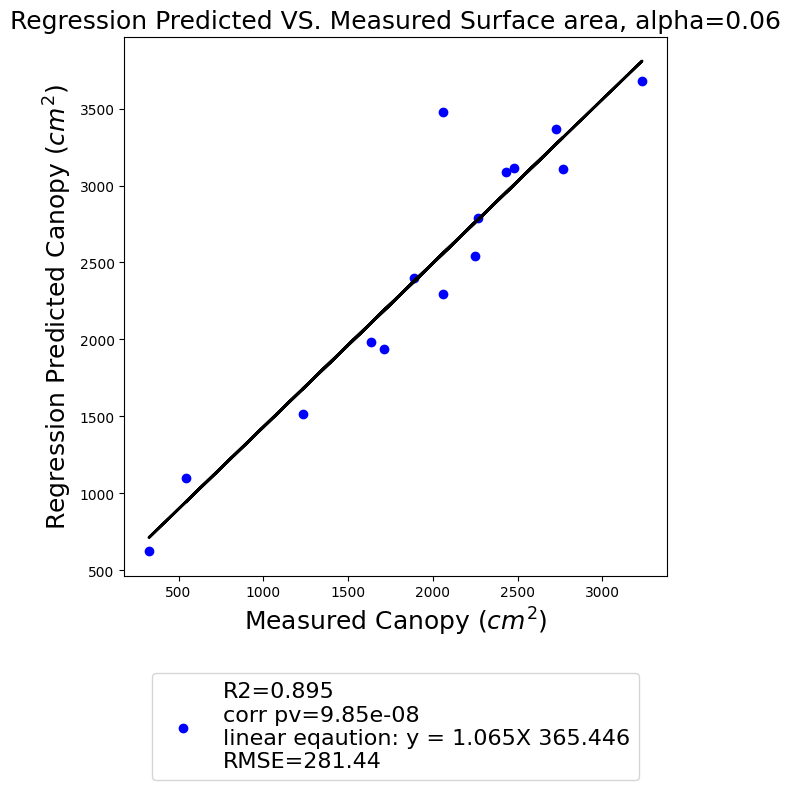

In [74]:
### using predict_stem_area() to predict canopy area from total area - subtracting the derived stem 
### area from the total area.
expected_leaf_area_by_factor['regression_predicted_canopy_area'] = expected_leaf_area_by_factor['total_area']- expected_leaf_area_by_factor['total_area'].apply(predict_stem_area)

### correlating between the measured canopy area and the predicted canopy area
X = np.asarray(expected_leaf_area_by_factor['real_canopy_area'])
Y = np.asarray(expected_leaf_area_by_factor['regression_predicted_canopy_area'])

res = stats.pearsonr(X,Y)
r2 = round((res.statistic**2),3)
pv = round(res.pvalue,10)

regr = LinearRegression().fit(X.reshape(-1, 1), Y.reshape(-1, 1))
y_pred = regr.predict(X.reshape(-1, 1))
rmse = mean_squared_error(Y, y_pred, squared=False)


coef_ = round(regr.coef_[0][0],3)
intercept_ = round(regr.intercept_[0],3)
eqaution = f"y = {coef_}X {intercept_}"

x_linear = np.linspace(X.min(),X.max(),100)
y_linear = x_linear


plt.figure(figsize=(7,7))

plt.scatter(X, Y, color="blue", label=f'R2={r2}\ncorr pv={pv}\nlinear eqaution: {eqaution}\nRMSE={rmse:.2f}')
plt.plot(X, y_pred, color="black", linewidth=2)
plt.title(f'Regression Predicted VS. Measured Surface area, alpha={alpha}', fontsize=18)
plt.xlabel('Measured Canopy ($cm^2$)', fontsize=18)
plt.ylabel('Regression Predicted Canopy ($cm^2$)', fontsize=18)
plt.legend(fontsize=16, loc='lower center', bbox_to_anchor=(0.5, -0.4))

plt.show()


# 4) CNN model vs measured


In [76]:
### comparing the classification CNN model output to the labeled point clouds. the comparison is 
### between the canopy area of the same maize plant - one that was labeled manually, where the stem label = 1, 
### and the other that was classified with the cnn model, where the stem label = 1 as well. 
### the labeled\classified stem points would be removed and only the leaf points will remain.
### the cnn model ran 3 time with 3 stem raius parameters - 0.01, 0.02, 0.03.
### poiint cloud of plants 10 and 15 could not ran successfully in the model thus were removed.
### only filename containing 'refined_radius_0.01' , 'refined_radius_0.02' and 'refined_radius_0.03' would be 
### collected - these are the model ouputs.

stem_radius = [0.01, 0.02, 0.03]

model_plant_data = []

for radius in stem_radius:
    for subdir, dirs, files in os.walk(root_dir):
        for filename in files:
            if "labeled" in filename or 'nor' in filename:# or "13" in filename  
                pass
            elif f'refined_radius_{radius}' in filename:
                pcd_file_path = os.path.join(subdir, filename)
                print(pcd_file_path)
                plant_num = filename.split('_')[1]
                print(f"plant_num - {plant_num}")
                points, labels = load_pcd(pcd_file_path)
                leaves_data = calculate_area_for_each_organ(plant_num, points, labels, radius)
                model_plant_data.extend(leaves_data)



model_plant_data = pd.DataFrame(model_plant_data)
model_plant_data = model_plant_data.merge(summed[['plant_num','leaf_summed_area']], on='plant_num')
model_plant_data.rename(columns={"leaf_summed_area": "real_canopy_area"}, inplace=True)

### adding 'succeeded' log to plants that the model was able to identify stem points
model_plant_data.loc[(model_plant_data['plant_num'] == '18') | (model_plant_data['plant_num'] == '17')| (model_plant_data['plant_num'] == '14') | (model_plant_data['plant_num'] == '13')  , ['model_log']] = 'succeeded'
model_plant_data = model_plant_data.fillna('failed')

### creating a dict for the scatter plot later
colors = {'succeeded':'tab:green', 'failed':'tab:red'}
model_plant_data




/Users/gabrielbar-sella/Documents/studies/research_project/3D_Corn_Phenotype/samples/round_2/28.2.23/18/28.2.23_18_constructed_refined_radius_0.01.txt
plant_num - 18
Reconstructing surface using Alpha Shapes algorithm...
organ_type - leaf, organ_num - -1, surface_area = 2718.277(squared cm)
Reconstructing surface using Alpha Shapes algorithm...
organ_type - stem, organ_num - 1, surface_area = 116.43(squared cm)
/Users/gabrielbar-sella/Documents/studies/research_project/3D_Corn_Phenotype/samples/round_2/28.2.23/9/28.2.23_9_constructed_refined_radius_0.01.txt
plant_num - 9
Reconstructing surface using Alpha Shapes algorithm...
organ_type - leaf, organ_num - -1, surface_area = 3521.663(squared cm)
/Users/gabrielbar-sella/Documents/studies/research_project/3D_Corn_Phenotype/samples/round_2/28.2.23/11/28.2.23_11_constructed_refined_radius_0.01.txt
plant_num - 11
Reconstructing surface using Alpha Shapes algorithm...
organ_type - leaf, organ_num - -1, surface_area = 1256.367(squared cm)
/Use

organ_type - leaf, organ_num - -1, surface_area = 3426.635(squared cm)
Reconstructing surface using Alpha Shapes algorithm...
organ_type - stem, organ_num - 1, surface_area = 337.275(squared cm)
/Users/gabrielbar-sella/Documents/studies/research_project/3D_Corn_Phenotype/samples/round_2/28.2.23/18/28.2.23_18_constructed_refined_radius_0.03.txt
plant_num - 18
Reconstructing surface using Alpha Shapes algorithm...
organ_type - leaf, organ_num - -1, surface_area = 2571.251(squared cm)
Reconstructing surface using Alpha Shapes algorithm...
organ_type - stem, organ_num - 1, surface_area = 413.831(squared cm)
/Users/gabrielbar-sella/Documents/studies/research_project/3D_Corn_Phenotype/samples/round_2/28.2.23/9/28.2.23_9_constructed_refined_radius_0.03.txt
plant_num - 9
Reconstructing surface using Alpha Shapes algorithm...
organ_type - leaf, organ_num - -1, surface_area = 3521.663(squared cm)
/Users/gabrielbar-sella/Documents/studies/research_project/3D_Corn_Phenotype/samples/round_2/28.2.23

,plant_num,organ_type,organ_num,calculated_area,radius,real_canopy_area,model_log
0,18,leaf,-1,2718.277,0.01,1891.095,succeeded
1,18,stem,1,116.430,0.01,1891.095,succeeded
2,18,leaf,-1,2692.914,0.02,1891.095,succeeded
3,18,stem,1,294.056,0.02,1891.095,succeeded
4,18,leaf,-1,2571.251,0.03,1891.095,succeeded
5,18,stem,1,413.831,0.03,1891.095,succeeded
6,9,leaf,-1,3521.663,0.01,2766.653,failed
7,9,leaf,-1,3521.663,0.02,2766.653,failed
8,9,leaf,-1,3521.663,0.03,2766.653,failed
9,11,leaf,-1,1256.367,0.01,541.852,failed


In [77]:
# model_plant_data.loc[(model_plant_data['radius'] == 0.03)].sort_values(by=['real_canopy_area'], ascending=True)

# model_plant_data.loc[(model_plant_data['organ_type'] == 'stem')].sort_values(by=['real_canopy_area'], ascending=True)

# model_plant_data.loc[(model_plant_data['plant_num'] == '13')].sort_values(by=['real_canopy_area'], ascending=True)

# model_plant_data.loc[(model_plant_data['organ_type'] != 'stem'), ['plant_num', 'calculated_area', 'radius']].sort_values(by=['calculated_area'], ascending=True)



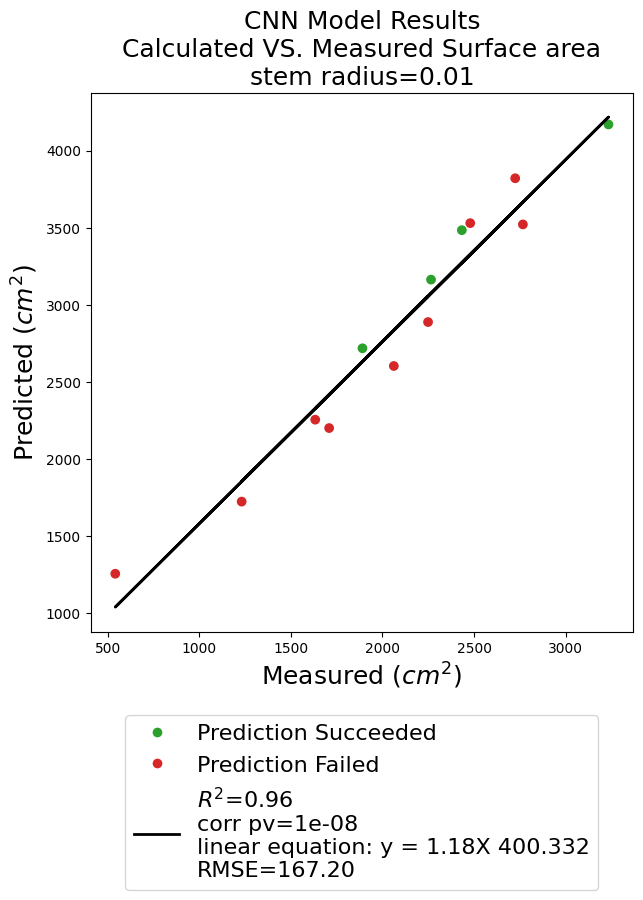

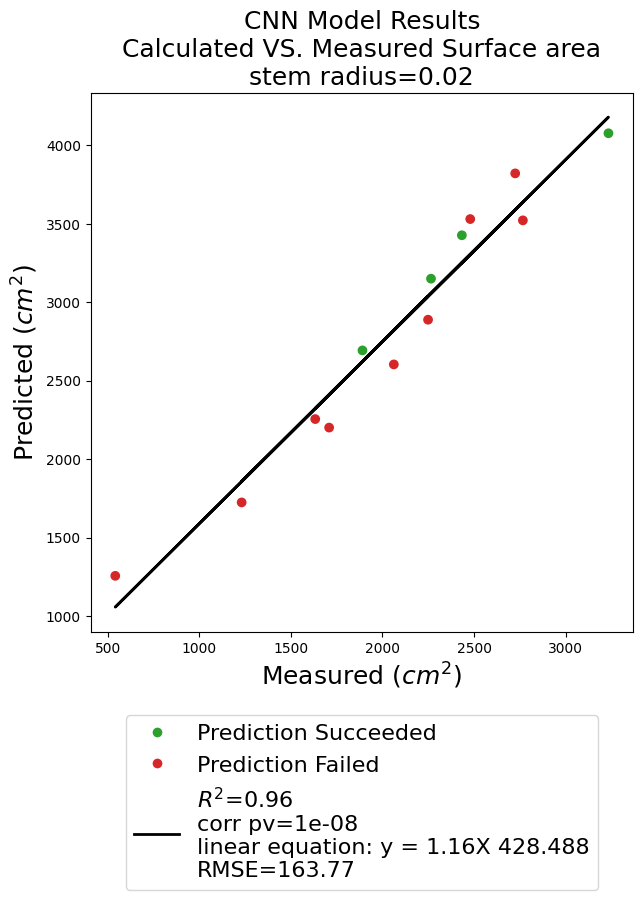

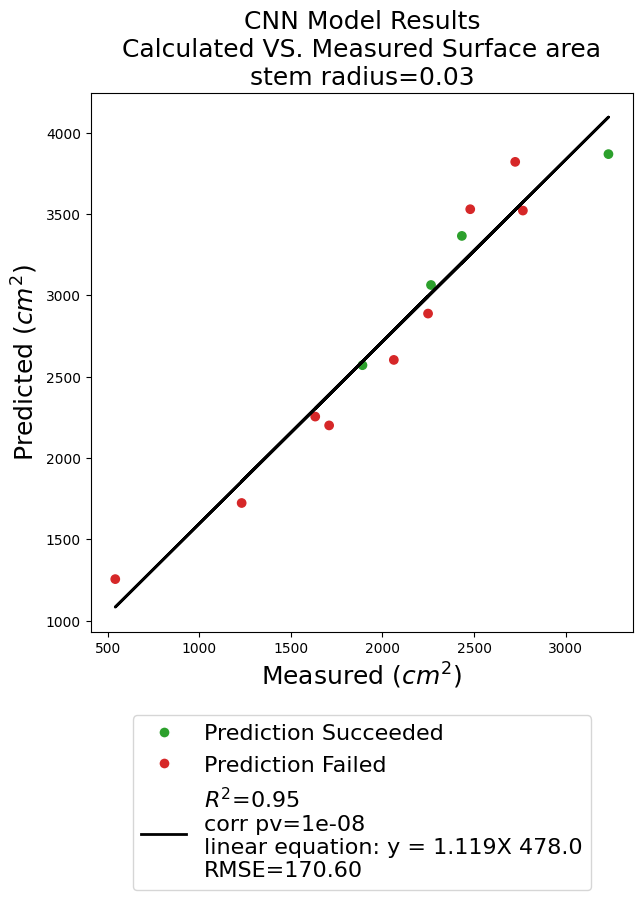

In [79]:
### correlating between the canopy area calculated from the CNN model results, for each radius value
### and the real_canopy_area of each plant


for radius in stem_radius:

    X = np.asarray(model_plant_data.loc[(model_plant_data['organ_type'] == 'leaf') & (model_plant_data['radius'] == radius),'real_canopy_area'])
    Y = np.asarray(model_plant_data.loc[(model_plant_data['organ_type'] == 'leaf') & (model_plant_data['radius'] == radius),'calculated_area'])
    C = model_plant_data.loc[(model_plant_data['organ_type'] == 'leaf') & (model_plant_data['radius'] == radius),'model_log']
    
    res = stats.pearsonr(X,Y)
    r2 = round((res.statistic**2),2)
    pv = round(res.pvalue,8)

    regr = LinearRegression().fit(X.reshape(-1, 1), Y.reshape(-1, 1))
    y_pred = regr.predict(X.reshape(-1, 1))
    rmse = mean_squared_error(Y, y_pred, squared=False)

    coef_ = round(regr.coef_[0][0],3)
    intercept_ = round(regr.intercept_[0],3)
    eqaution = f"y = {coef_}X {intercept_}"

    x_linear = np.linspace(X.min(),X.max(),100)
    y_linear = x_linear


    plt.figure(figsize=(7,7))

    plt.scatter(X, Y, c=C.map(colors)) 

    plt.plot(X, y_pred, color="black", linewidth=2)
    plt.title(f'CNN Model Results\nCalculated VS. Measured Surface area\nstem radius={radius}', fontsize=18)
    plt.xlabel('Measured ($cm^2$)', fontsize=18)
    plt.ylabel('Predicted ($cm^2$)', fontsize=18)

    regression_label = f'$R^2$={r2}\ncorr pv={pv}\nlinear equation: {eqaution}\nRMSE={rmse:.2f}'
    linear_line_label = f'y=x'
    
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Prediction Succeeded', markerfacecolor='tab:green', markersize=8),
                       plt.Line2D([0], [0], marker='o', color='w', label='Prediction Failed', markerfacecolor='tab:red', markersize=8),
                       plt.Line2D([0], [0], color='black', linewidth=2, label=regression_label)]

    plt.legend(handles=legend_elements, fontsize=16, loc='lower center', bbox_to_anchor=(0.5, -0.5))
    plt.show()
    
    


# Daily transpiration comparison

In [83]:
### Parsing the Daily transpiration data file from plant array

pots_location = {"A01" : "1", "B01" : "2", "C01" : "3", "A02" : "4", "B02" : "5", "C02" : "6", "D02" : "7", "A03" : "8", "B03" : "9", "D03" : "10", "A04" : "11", "B04" : "12", "C04" : "13", "D04" : "14", "A05" : "15", "B05" : "16", "C05" : "17", "D05" : "18", "A06" : "19", "B06" : "20"}

transpiration_file = 'Daily_Transpiration.csv'
transpiration_data_path = os.path.join(working_directory, transpiration_file)
transpiration_data = pd.read_csv(transpiration_data_path, sep='\t', header=0)
transpiration_data.columns

transpiration_data = transpiration_data[transpiration_data['Timestamp'] == '2023-02-27T00:00:00']

output_transpiration_file = 'transpiration.csv'
output_transpiration_path = os.path.join(working_directory, output_transpiration_file)

transpiration_data.T.to_csv(output_transpiration_path)



In [84]:
def fix_col(col):
    return pots_location[col.split(' - ')[0]]

In [86]:
### merging the transpiration data and the canopy area from different approaches

transpiration_data = pd.read_csv(output_transpiration_path, sep=',',skiprows=1, header=0)
transpiration_data.columns = ['plant_num', 'transpiration']
transpiration_data['plant_num'] = transpiration_data['plant_num'].apply(fix_col)


transpiration_data = transpiration_data.merge(summed[['plant_num','leaf_summed_area', 'total_area']], how='inner', on='plant_num')
transpiration_data.rename(columns={"leaf_summed_area": "labeled_canopy_area", "stem_summed_area": "real_stem_area"}, inplace=True)

transpiration_data = transpiration_data.merge(expected_leaf_area_by_factor[['plant_num', 'expected_canopy_area']], how='inner', on='plant_num')
transpiration_data.rename(columns={"expected_canopy_area": "factor_canopy_area"}, inplace=True)


model_results = model_plant_data.loc[(model_plant_data['organ_type'] != 'stem'), ['plant_num', 'calculated_area', 'radius', 'model_log']].sort_values(by=['calculated_area'], ascending=True)
model_results = pd.pivot_table(model_results, values='calculated_area', index=['plant_num','model_log'] , columns='radius').reset_index()
model_results.columns = ['plant_num','model_log', 'cnn_radius_0.01', 'cnn_radius_0.02', 'cnn_radius_0.03']
transpiration_data = transpiration_data.merge(model_results, how='inner', on='plant_num')

cols = transpiration_data.columns.tolist()
cols = cols[:2] + cols[5:6] + cols[2:5] + cols[6:]
transpiration_data = transpiration_data[cols]

output_transpiration_vs_area_file = 'transpiration_vs_area'
output_transpiration_vs_area_path = os.path.join(working_directory, output_transpiration_vs_area_file)

transpiration_data.to_csv(output_transpiration_vs_area_path)

transpiration_data



,plant_num,transpiration,model_log,labeled_canopy_area,total_area,factor_canopy_area,cnn_radius_0.01,cnn_radius_0.02,cnn_radius_0.03
0,1,37.97,failed,1231.693,1359.372,1525.873346,1724.155,1724.155,1724.155
1,8,71.57,failed,2062.331,2280.350,2304.258352,2603.650,2603.650,2603.650
2,11,33.80,failed,541.852,627.022,1111.867577,1256.367,1256.367,1256.367
3,2,98.36,failed,1633.310,1831.227,1995.958970,2255.337,2255.337,2255.337
4,9,113.33,failed,2766.653,3099.501,3116.583494,3521.663,3521.663,3521.663
5,16,110.55,failed,2479.284,2820.904,3123.938621,3529.927,3529.927,3529.927
6,3,78.10,failed,2249.073,2561.133,2556.259285,2888.460,2888.460,2888.460
7,6,93.57,failed,2724.709,3063.228,3381.420279,3820.954,3820.954,3820.954
8,13,123.66,succeeded,3233.650,3688.020,3690.632967,4169.738,4076.570,3868.557
9,17,116.73,succeeded,2265.225,2515.536,2801.343160,3163.741,3149.995,3064.108


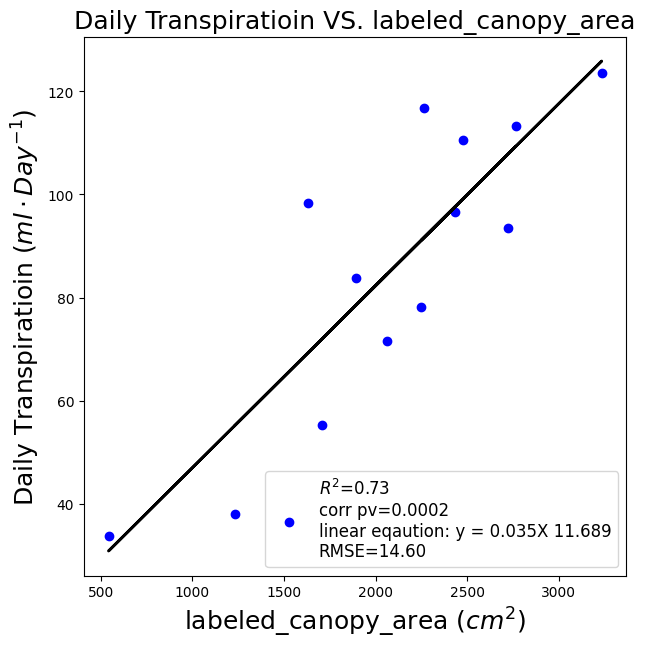

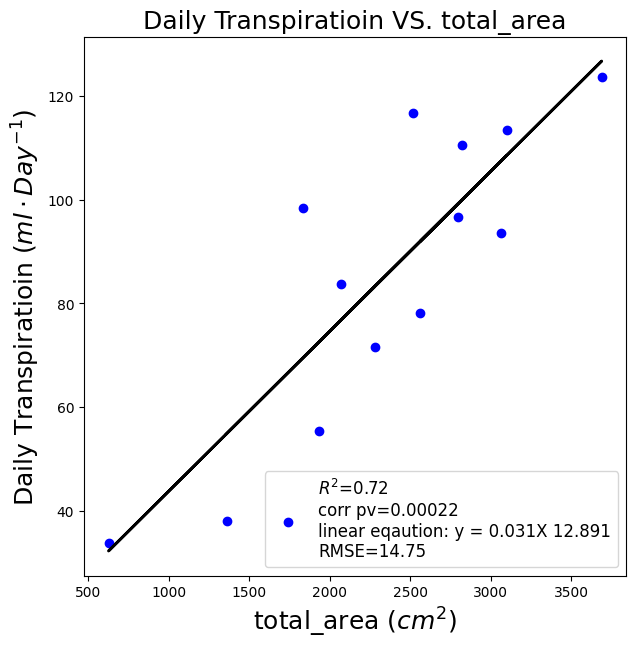

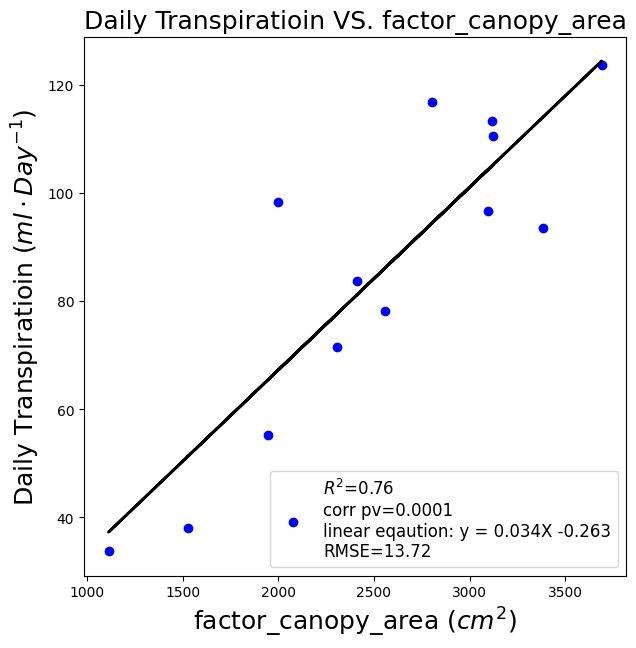

In [148]:
### correlations between the transpiration and labeled_canopy_area, total_area, factor_canopy_area
for i in transpiration_data.columns[3:6]:

    X = np.asarray(transpiration_data[i])
    Y = np.asarray(transpiration_data['transpiration'])

    res = stats.pearsonr(X,Y)
    r2 = round((res.statistic**2),2)
    pv = round(res.pvalue,5)

    regr = LinearRegression().fit(X.reshape(-1, 1), Y.reshape(-1, 1))
    y_pred = regr.predict(X.reshape(-1, 1))
    rmse = mean_squared_error(Y, y_pred, squared=False)

        
    coef_ = round(regr.coef_[0][0],3)
    intercept_ = round(regr.intercept_[0],3)
    eqaution = f"y = {coef_}X {intercept_}"

    x_linear = np.linspace(X.min(),X.max(),100)
    y_linear = x_linear


    plt.figure(figsize=(7,7))

    plt.scatter(X, Y, color="blue", label=f'$R^2$={r2}\ncorr pv={pv}\nlinear eqaution: {eqaution}\nRMSE={rmse:.2f}')
    plt.plot(X, y_pred, color="black", linewidth=2)
    plt.title(f'Daily Transpiratioin VS. {i}', fontsize=18)
    plt.xlabel(f'{i} ($cm^2$)', fontsize=18)
    plt.ylabel('Daily Transpiratioin ($ml\cdot{Day}^{-1}$)', fontsize=18)
    plt.legend(fontsize=12)

    plt.show()


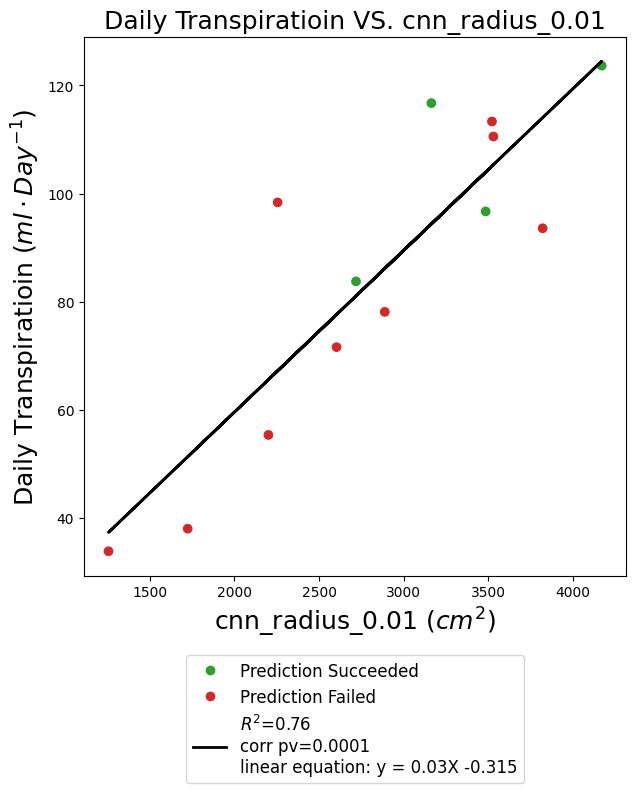

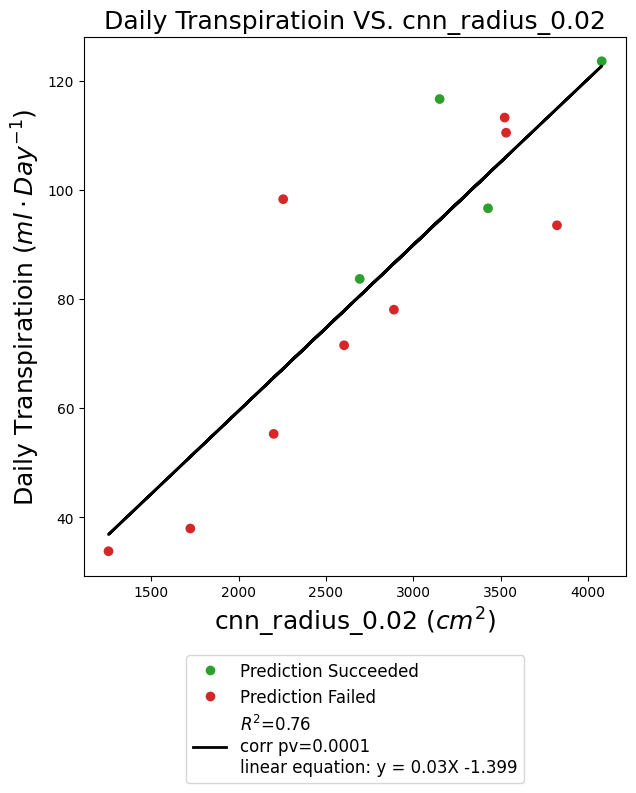

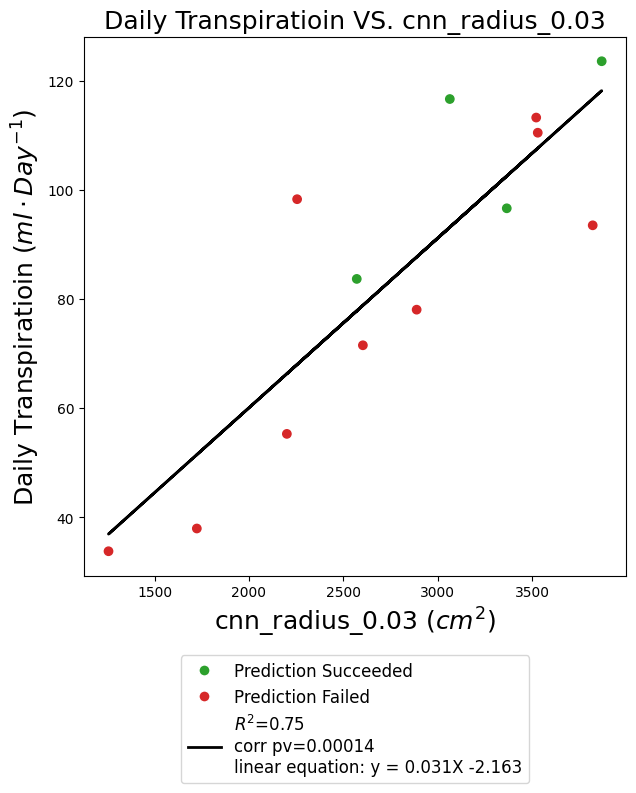

In [150]:
### correlations between the transpiration and CNN model outputs
for i in transpiration_data.columns[6:]:

    X = np.asarray(transpiration_data[i])
    Y = np.asarray(transpiration_data['transpiration'])
    C = transpiration_data['model_log']

    res = stats.pearsonr(X,Y)
    r2 = round((res.statistic**2),2)
    pv = round(res.pvalue,5)

    regr = LinearRegression().fit(X.reshape(-1, 1), Y.reshape(-1, 1))
    y_pred = regr.predict(X.reshape(-1, 1))

    coef_ = round(regr.coef_[0][0],3)
    intercept_ = round(regr.intercept_[0],3)
    eqaution = f"y = {coef_}X {intercept_}"

    x_linear = np.linspace(X.min(),X.max(),100)
    y_linear = x_linear


    plt.figure(figsize=(7,7))

    plt.scatter(X, Y, c=C.map(colors))
    plt.plot(X, y_pred, color="black", linewidth=2)
    plt.title(f'Daily Transpiratioin VS. {i}', fontsize=18)
    plt.xlabel(f'{i} ($cm^2$)', fontsize=18)
    plt.ylabel('Daily Transpiratioin ($ml\cdot{Day}^{-1}$)', fontsize=18)
    
    regression_label = f'$R^2$={r2}\ncorr pv={pv}\nlinear equation: {eqaution}'
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Prediction Succeeded', markerfacecolor='tab:green', markersize=8),
                       plt.Line2D([0], [0], marker='o', color='w', label='Prediction Failed', markerfacecolor='tab:red', markersize=8),
                       plt.Line2D([0], [0], color='black', linewidth=2, label=regression_label)]
    
    plt.legend(handles=legend_elements, fontsize=12, loc='lower center', bbox_to_anchor=(0.5, -0.4))

    plt.show()

# t-test for daily transpiration predictors

In [105]:
### preparing data for t-test, creating a list of pairs of predictors to compare between
predictors_data = pd.read_csv(output_transpiration_vs_area_path)
predictors = list(predictors_data.columns[4:])
pairs = list(itertools.combinations(predictors, 2))

predictors_data

,Unnamed: 0,plant_num,transpiration,model_log,labeled_canopy_area,total_area,factor_canopy_area,cnn_radius_0.01,cnn_radius_0.02,cnn_radius_0.03
0,0,1,37.97,failed,1231.693,1359.372,1525.873346,1724.155,1724.155,1724.155
1,1,8,71.57,failed,2062.331,2280.350,2304.258352,2603.650,2603.650,2603.650
2,2,11,33.80,failed,541.852,627.022,1111.867577,1256.367,1256.367,1256.367
3,3,2,98.36,failed,1633.310,1831.227,1995.958970,2255.337,2255.337,2255.337
4,4,9,113.33,failed,2766.653,3099.501,3116.583494,3521.663,3521.663,3521.663
5,5,16,110.55,failed,2479.284,2820.904,3123.938621,3529.927,3529.927,3529.927
6,6,3,78.10,failed,2249.073,2561.133,2556.259285,2888.460,2888.460,2888.460
7,7,6,93.57,failed,2724.709,3063.228,3381.420279,3820.954,3820.954,3820.954
8,8,13,123.66,succeeded,3233.650,3688.020,3690.632967,4169.738,4076.570,3868.557
9,9,17,116.73,succeeded,2265.225,2515.536,2801.343160,3163.741,3149.995,3064.108


In [99]:
### running t-test between each pair, adding the significant pairs to significant_pairs
significant_pairs =[]

for i in pairs:
#     print(i)
    pv = stats.ttest_ind(predictors_data[i[0]], predictors_data[i[1]])[1]
    if pv < 0.05:
        print(i[0],' - ',round(predictors_data[i[0]].mean(),2), i[1],' - ',round(predictors_data[i[1]].mean(),2), 'pv - ', round(pv,3))
        significant_pairs.append((i[0], i[1]))




labeled_canopy_area  -  2093.97 cnn_radius_0.01  -  2872.13 pv -  0.018
labeled_canopy_area  -  2093.97 cnn_radius_0.02  -  2857.51 pv -  0.019
labeled_canopy_area  -  2093.97 cnn_radius_0.03  -  2820.86 pv -  0.023


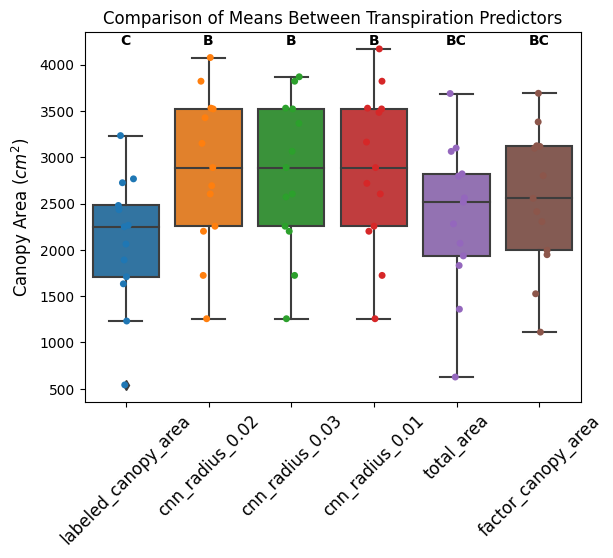

In [100]:
### list of unique predictors to add to the plot
unique_predictors = ['labeled_canopy_area', 'cnn_radius_0.02', 'cnn_radius_0.03', 'cnn_radius_0.01', 'total_area', 'factor_canopy_area']

### letters for each predictor group
predictor_letters = {'labeled_canopy_area': 'C', 'cnn_radius_0.02': 'B', 'cnn_radius_0.03': 'B', 'cnn_radius_0.01': 'B', 'total_area': 'BC', 'factor_canopy_area': 'BC'}

sns.boxplot(data=predictors_data[unique_predictors], saturation=0.75)
sns.stripplot(data=predictors_data[unique_predictors], alpha=1)

### getting the boxex hights to add the letters above them
y_max = predictors_data[unique_predictors].max().max()  

for predictor in unique_predictors:
    x = unique_predictors.index(predictor)
    letter = predictor_letters[predictor]
    y = y_max + (0.02 * y_max)  
    plt.text(x, y, letter, ha='center', va='center', fontweight='bold')

plt.ylabel(f'Canopy Area ($cm^2$)', fontsize=12)
plt.title('Comparison of Means Between Transpiration Predictors', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.show()


# Point Cloud Resolution

In [108]:
### computing the #error for each leaf, and the the average of this value for each plant

resolution = data_merged[data_merged['organ_type'] == 'leaf']
resolution['%error'] = abs((resolution['calculated_area']-resolution['measured_area'])) / resolution['measured_area'] * 100

resolution = resolution.groupby('plant_num')['%error'].mean().reset_index(name='mean_error')
resolution

/var/folders/6p/xh3xvqks229bxk65zf9ht6v40000gn/T/ipykernel_98797/4232439486.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resolution['%error'] = abs((resolution['calculated_area']-resolution['measured_area'])) / resolution['measured_area'] * 100


,plant_num,mean_error
0,1,54.412750
1,10,49.042219
2,11,33.593168
3,13,127.389048
4,14,23.621749
5,15,46.498340
6,16,57.677295
7,17,43.982029
8,18,34.735685
9,2,31.210449


In [109]:
### getting point count for each plant and computing the volum of each point cloud 
whole_plant_data = []


for subdir, dirs, files in os.walk(root_dir):
    for filename in files:
        if "labeled" in filename  or 'nor' in filename: #or "13" in filename: 
            pass
        elif 'edited_no_rgb' in filename:
            pcd_file_path = os.path.join(subdir, filename)
            print(pcd_file_path)
            plant_num = filename.split('_')[1]
            points = load_pcd(pcd_file_path)
            num_points = points.shape[0]
            print(plant_num)
            print(num_points)
        
            resolution.loc[resolution['plant_num'] == plant_num, 'points'] = int(num_points)
            X = np.max(points[0]) - np.min(points[0])
            Y = np.max(points[1]) - np.min(points[1])
            Z = np.max(points[2]) - np.min(points[2])
            print(X, Y, Z)
            volume = X*Y*Z
            resolution.loc[resolution['plant_num'] == plant_num, 'volume_cm2'] = volume*10000



/Users/gabrielbar-sella/Documents/studies/research_project/3D_Corn_Phenotype/samples/round_2/28.2.23/18/28.2.23_18_edited_no_rgb.txt
18
9162
0.21895509999999999 0.20686305 0.21133149
/Users/gabrielbar-sella/Documents/studies/research_project/3D_Corn_Phenotype/samples/round_2/28.2.23/9/28.2.23_9_edited_no_rgb.txt
9
13116
0.24949471999999998 0.24671655999999997 0.24771970999999998
/Users/gabrielbar-sella/Documents/studies/research_project/3D_Corn_Phenotype/samples/round_2/28.2.23/11/28.2.23_11_edited_no_rgb.txt
11
2116
0.63778803 0.62872956 0.60867465
/Users/gabrielbar-sella/Documents/studies/research_project/3D_Corn_Phenotype/samples/round_2/28.2.23/7/28.2.23_7_edited_no_rgb.txt
7
3480
1.40541142 1.40957547 1.3957103499999999
/Users/gabrielbar-sella/Documents/studies/research_project/3D_Corn_Phenotype/samples/round_2/28.2.23/16/28.2.23_16_edited_no_rgb.txt
16
13535
0.22660847 0.22878118 0.30712244
/Users/gabrielbar-sella/Documents/studies/research_project/3D_Corn_Phenotype/samples/round

In [110]:
### pcd frames extracted from the Polycam app for each of the 15 point clouds

pcd_frames_file = 'pcd_frames.csv'
pcd_frames_path = os.path.join(working_directory, pcd_frames_file)

pcd_frames = pd.read_csv(pcd_frames_path, delimiter=',')
pcd_frames = pcd_frames.astype({"plant_num": str})

resolution = resolution.merge(pcd_frames, on='plant_num')

resolution['points_per_cm'] = resolution['points'] / resolution['volume_cm2']
resolution

,plant_num,mean_error,points,volume_cm2,frames,points_per_cm
0,1,54.412750,6090.0,1175.491969,123,5.180810
1,10,49.042219,28666.0,224.424118,159,127.731369
2,11,33.593168,2116.0,2440.762141,111,0.866942
3,13,127.389048,15332.0,37.065625,193,413.644722
4,14,23.621749,16623.0,1069.308397,200,15.545562
5,15,46.498340,2070.0,967.819881,102,2.138828
6,16,57.677295,13535.0,159.223800,146,85.006136
7,17,43.982029,7496.0,5331.128993,129,1.406081
8,18,34.735685,9162.0,95.719893,126,95.716781
9,2,31.210449,5556.0,4015.140210,135,1.383762


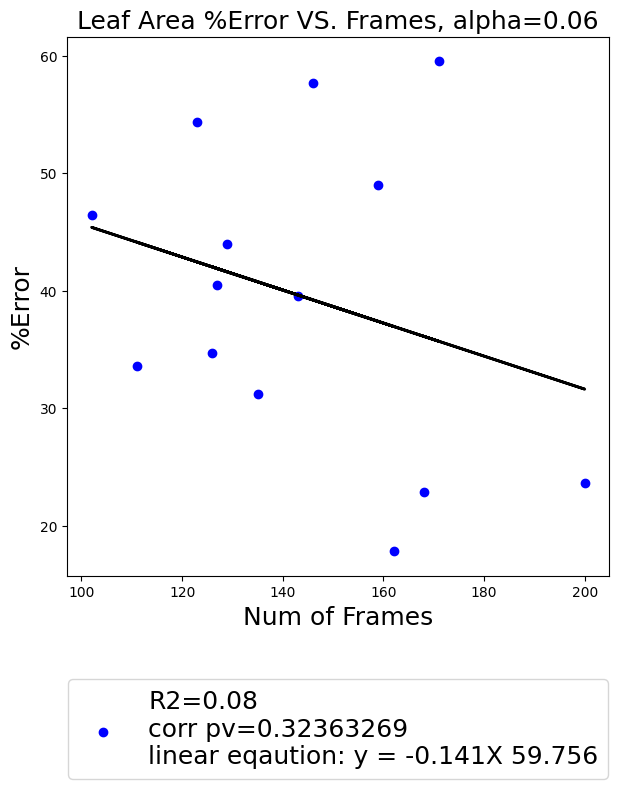

In [111]:
### %ERROR vs num of frames - not including plant 13 (oulier)

X = np.asarray(resolution.loc[resolution['plant_num'] != '13', 'frames'])
Y = np.asarray(resolution.loc[resolution['plant_num'] != '13', 'mean_error'])


res = stats.pearsonr(X,Y)
r2 = round((res.statistic**2),2)
pv = round(res.pvalue,8)

regr = LinearRegression().fit(X.reshape(-1, 1), Y.reshape(-1, 1))
y_pred = regr.predict(X.reshape(-1, 1))

coef_ = round(regr.coef_[0][0],3)
intercept_ = round(regr.intercept_[0],3)
eqaution = f"y = {coef_}X {intercept_}"

x_linear = np.linspace(X.min(),X.max(),100)
y_linear = x_linear


plt.figure(figsize=(7,7))

plt.scatter(X, Y, color="blue", label=f'R2={r2}\ncorr pv={pv}\nlinear eqaution: {eqaution}')
plt.plot(X, y_pred, color="black", linewidth=2)
plt.title(f'Leaf Area %Error VS. Frames, alpha={alpha}', fontsize=18)
plt.xlabel('Num of Frames', fontsize=18)
plt.ylabel('%Error', fontsize=18)
plt.legend(fontsize=18, loc='lower center', bbox_to_anchor=(0.5, -0.4))
plt.show()


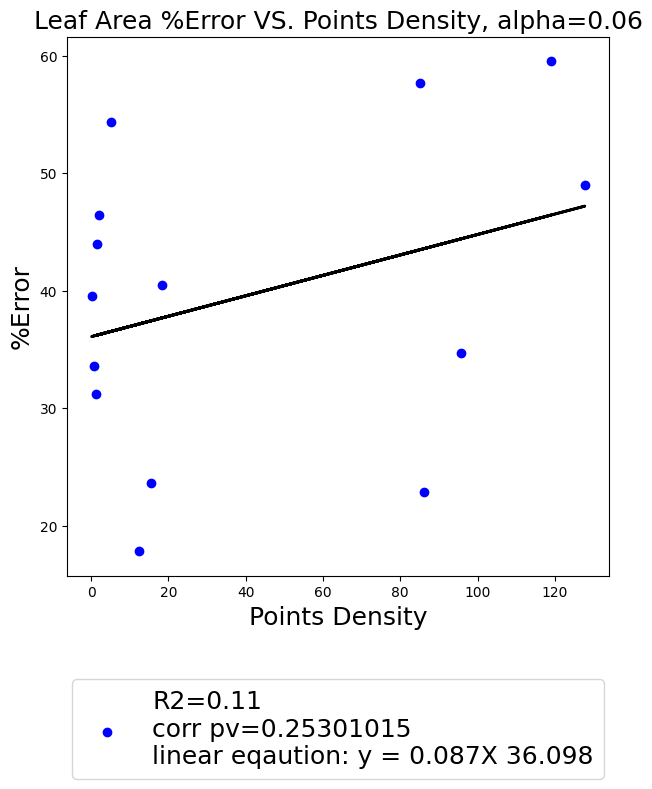

In [374]:
## %ERROR vs point density - not including plant 13 (oulier)


X = np.asarray(resolution.loc[resolution['plant_num'] != '13', 'points_per_cm'])
Y = np.asarray(resolution.loc[resolution['plant_num'] != '13', 'mean_error'])


res = stats.pearsonr(X,Y)
r2 = round((res.statistic**2),2)
pv = round(res.pvalue,8)

regr = LinearRegression().fit(X.reshape(-1, 1), Y.reshape(-1, 1))
y_pred = regr.predict(X.reshape(-1, 1))

coef_ = round(regr.coef_[0][0],3)
intercept_ = round(regr.intercept_[0],3)
eqaution = f"y = {coef_}X {intercept_}"

x_linear = np.linspace(X.min(),X.max(),100)
y_linear = x_linear


plt.figure(figsize=(7,7))

plt.scatter(X, Y, color="blue", label=f'R2={r2}\ncorr pv={pv}\nlinear eqaution: {eqaution}')
plt.plot(X, y_pred, color="black", linewidth=2)
plt.title(f'Leaf Area %Error VS. Points Density, alpha={alpha}', fontsize=18)
plt.xlabel('Points Density', fontsize=18)
plt.ylabel('%Error', fontsize=18)
plt.legend(fontsize=18, loc='lower center', bbox_to_anchor=(0.5, -0.4))
plt.show()


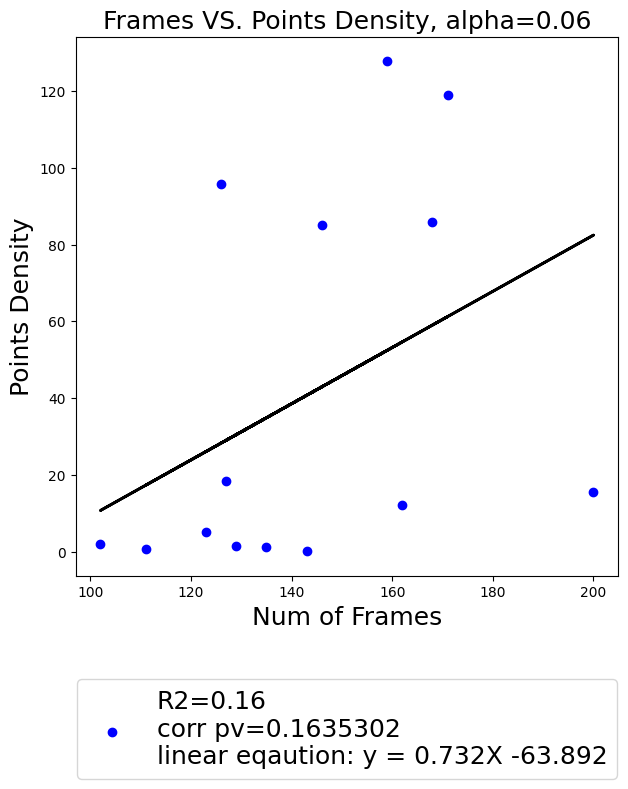

In [115]:
### point density vs frames - not including plant 13

X = np.asarray(resolution.loc[resolution['plant_num'] != '13', 'frames'])
Y = np.asarray(resolution.loc[resolution['plant_num'] != '13', 'points_per_cm'])


res = stats.pearsonr(X,Y)
r2 = round((res.statistic**2),2)
pv = round(res.pvalue,8)

regr = LinearRegression().fit(X.reshape(-1, 1), Y.reshape(-1, 1))
y_pred = regr.predict(X.reshape(-1, 1))

coef_ = round(regr.coef_[0][0],3)
intercept_ = round(regr.intercept_[0],3)
eqaution = f"y = {coef_}X {intercept_}"

x_linear = np.linspace(X.min(),X.max(),100)
y_linear = x_linear


plt.figure(figsize=(7,7))

plt.scatter(X, Y, color="blue", label=f'R2={r2}\ncorr pv={pv}\nlinear eqaution: {eqaution}')
plt.plot(X, y_pred, color="black", linewidth=2)
plt.title(f'Frames VS. Points Density, alpha={alpha}', fontsize=18)
plt.xlabel('Num of Frames', fontsize=18)
plt.ylabel('Points Density', fontsize=18)
plt.legend(fontsize=18, loc='lower center', bbox_to_anchor=(0.5, -0.4))
plt.show()

# growth (total area) & transpiration over time

In [117]:
### iterating through all the point clouds from all the dates to track the change in plants total surface area
all_pcd_data = "samples/round_2/"
all_pcd_root_dir = os.path.join(working_directory, all_pcd_data)

plant_growth_data = []
participating_plants = ['1','2','3','6','7','8','10','13','14','16','17','18']

for subdir, dirs, files in os.walk(all_pcd_root_dir):
    for filename in files:
        if "labeled" in filename  or 'nor' in filename: #or "13" in filename: 
            pass
        elif 'edited_no_rgb' in filename:
            pcd_file_path = os.path.join(subdir, filename)
            plant_num = filename.split('_')[1]

            if plant_num in participating_plants:
                print(pcd_file_path)
                date = filename.split('_')[0]
                print(f"plant_num - {plant_num}, date - {date}\n\n")
                points = load_pcd(pcd_file_path)
                plant_pcd = o3d.geometry.PointCloud()
                organ_type = 'whole_plant'
                plant_pcd.points = o3d.utility.Vector3dVector(points)
                surface_area = extract_surface_area_methods(plant_pcd, 'AlphaShapes', organ_type, alpha=alpha)
                print(f"organ_type - {organ_type} , surface_area = {surface_area}(squared cm)")
                data = {"plant_num": plant_num, "date": date, 'organ_type': organ_type, "calculated_area": surface_area}
                plant_growth_data.append(data)
                print('\n')

plant_growth_data = pd.DataFrame(plant_growth_data)
plant_growth_data


/Users/gabrielbar-sella/Documents/studies/research_project/3D_Corn_Phenotype/samples/round_2/28.2.23/18/28.2.23_18_edited_no_rgb.txt
plant_num - 18, date - 28.2.23


Reconstructing surface using Alpha Shapes algorithm...
organ_type - whole_plant , surface_area = 2726.493(squared cm)


/Users/gabrielbar-sella/Documents/studies/research_project/3D_Corn_Phenotype/samples/round_2/28.2.23/7/28.2.23_7_edited_no_rgb.txt
plant_num - 7, date - 28.2.23


Reconstructing surface using Alpha Shapes algorithm...
organ_type - whole_plant , surface_area = 2200.907(squared cm)


/Users/gabrielbar-sella/Documents/studies/research_project/3D_Corn_Phenotype/samples/round_2/28.2.23/16/28.2.23_16_edited_no_rgb.txt
plant_num - 16, date - 28.2.23


Reconstructing surface using Alpha Shapes algorithm...
organ_type - whole_plant , surface_area = 3529.926(squared cm)


/Users/gabrielbar-sella/Documents/studies/research_project/3D_Corn_Phenotype/samples/round_2/28.2.23/6/28.2.23_6_edited_no_rgb.txt
plant_num - 6,

organ_type - whole_plant , surface_area = 153.459(squared cm)


/Users/gabrielbar-sella/Documents/studies/research_project/3D_Corn_Phenotype/samples/round_2/15.2.23/10/15.2.23_10_edited_no_rgb.txt
plant_num - 10, date - 15.2.23


Reconstructing surface using Alpha Shapes algorithm...
organ_type - whole_plant , surface_area = 212.62(squared cm)


/Users/gabrielbar-sella/Documents/studies/research_project/3D_Corn_Phenotype/samples/round_2/15.2.23/8/15.2.23_8_edited_no_rgb.txt
plant_num - 8, date - 15.2.23


Reconstructing surface using Alpha Shapes algorithm...
organ_type - whole_plant , surface_area = 167.467(squared cm)


/Users/gabrielbar-sella/Documents/studies/research_project/3D_Corn_Phenotype/samples/round_2/15.2.23/3/15.2.23_3_edited_no_rgb.txt
plant_num - 3, date - 15.2.23


Reconstructing surface using Alpha Shapes algorithm...
organ_type - whole_plant , surface_area = 566.771(squared cm)


/Users/gabrielbar-sella/Documents/studies/research_project/3D_Corn_Phenotype/samples/rou

,plant_num,date,organ_type,calculated_area
0,18,28.2.23,whole_plant,2726.493
1,7,28.2.23,whole_plant,2200.907
2,16,28.2.23,whole_plant,3529.926
3,6,28.2.23,whole_plant,3820.870
4,17,28.2.23,whole_plant,3165.406
5,1,28.2.23,whole_plant,1724.176
6,10,28.2.23,whole_plant,3941.467
7,8,28.2.23,whole_plant,2603.720
8,3,28.2.23,whole_plant,2888.471
9,2,28.2.23,whole_plant,2255.354


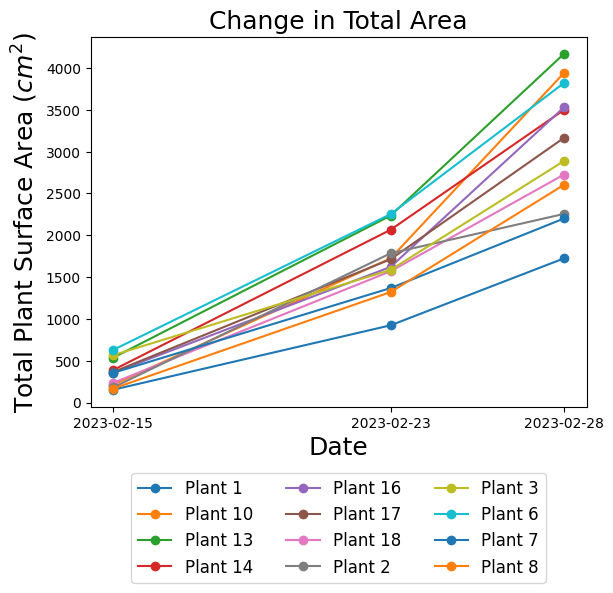

In [118]:
### plot the growth data over time, convert the 'date' column to datetime type

plant_growth_data['date'] = pd.to_datetime(plant_growth_data['date'])
plant_growth_data = plant_growth_data.sort_values('date')
grouped_data = plant_growth_data.groupby('plant_num')


fig, ax = plt.subplots()
for plant_num, group in grouped_data:
    ax.plot(group['date'], group['calculated_area'], 'o-', label=f'Plant {plant_num}')


ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Total Plant Surface Area ($cm^2$)', fontsize=18)
ax.set_title('Change in Total Area', fontsize=18)
ax.legend(fontsize=12, loc='lower center', ncols = 3, bbox_to_anchor=(0.5, -0.5))

dates = plant_growth_data['date'].unique()
ax.set_xticks(dates, rotation=30)
plt.show()

# transpiration over time

In [123]:
#### getting all the daily transpiration rate data 

# pots_location = {"A01" : "1", "B01" : "2", "C01" : "3", "A02" : "4", "B02" : "5", "C02" : "6", "D02" : "7", "A03" : "8", "B03" : "9", "D03" : "10", "A04" : "11", "B04" : "12", "C04" : "13", "D04" : "14", "A05" : "15", "B05" : "16", "C05" : "17", "D05" : "18", "A06" : "19", "B06" : "20"}

transpiration_data= 'Daily_Transpiration_all_time.csv'
transpiration_data_path = os.path.join(working_directory, transpiration_data)
transpiration_data = pd.read_csv(transpiration_data_path, sep=',', header=0)


transpiration_data = transpiration_data[transpiration_data['Timestamp'].isin(['2023-02-15T00:00:00','2023-02-23T00:00:00','2023-02-26T00:00:00']) ]
transpiration_data = transpiration_data.T.reset_index()
transpiration_data = transpiration_data.tail(-1)
transpiration_data.columns = ['plant_num', '2023-02-15', '2023-02-23', '2023-02-26']
transpiration_data['plant_num'] = transpiration_data['plant_num'].apply(fix_col)

transpiration_data = transpiration_data.loc[transpiration_data['plant_num'].isin(participating_plants)]

### pivotind the dataframe to change format
transpiration_data = pd.melt(
    transpiration_data,
    id_vars='plant_num',
    var_name='date',
    value_name='transpiration_data'
)


transpiration_data = transpiration_data.sort_values('date')
transpiration_data


,plant_num,date,transpiration_data
0,1,2023-02-15,13.83
11,18,2023-02-15,-3.44
10,14,2023-02-15,29.02
9,10,2023-02-15,30.22
7,17,2023-02-15,32.97
6,13,2023-02-15,40.62
8,7,2023-02-15,25.23
4,3,2023-02-15,30.75
3,16,2023-02-15,35.89
2,2,2023-02-15,28.43


In [124]:
### function to crate a new colum to enable joining the dataframes as 2023-02-26 was selected instead of 2023-02-28
def update_date(row):
    if row['date'] == '2023-02-26':
        return '2023-02-28'
    else:
        return row['date']

transpiration_data['date_to_join'] = transpiration_data.apply(update_date, axis=1)


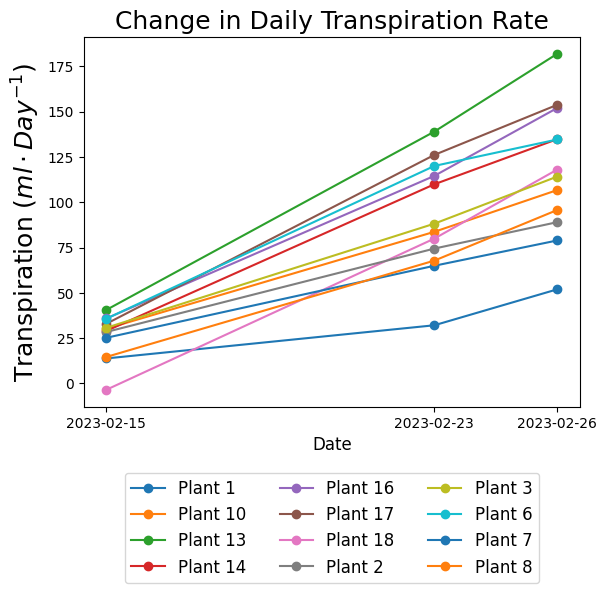

In [125]:
### converting 'date' and 'date_to_join' columnd to datetime type to enable joining
transpiration_data['date'] = pd.to_datetime(transpiration_data['date'])
transpiration_data['date_to_join'] = pd.to_datetime(transpiration_data['date_to_join'])
transpiration_data = transpiration_data.sort_values('date')
grouped_data = transpiration_data.groupby('plant_num')


fig, ax = plt.subplots()


for plant_num, group in grouped_data:
    ax.plot(group['date'], group['transpiration_data'], 'o-', label=f'Plant {plant_num}')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Transpiration ($ml\cdot{Day}^{-1}$)', fontsize=18)
ax.set_title('Change in Daily Transpiration Rate', fontsize=18)
ax.legend(fontsize=12, loc='lower center', ncols = 3, bbox_to_anchor=(0.5, -0.5))
dates = transpiration_data['date'].unique()
ax.set_xticks(dates, rotation=30)
plt.show()

In [127]:
### joining transpiration data and growth data to a single dataframe
transpiration_growth_combined = pd.merge(transpiration_data[['plant_num','transpiration_data','date_to_join']], plant_growth_data,left_on=['plant_num', 'date_to_join'],right_on=['plant_num', 'date'], how='inner')
transpiration_growth_combined



,plant_num,transpiration_data,date_to_join,date,organ_type,calculated_area
0,1,13.83,2023-02-15,2023-02-15,whole_plant,153.459
1,6,35.77,2023-02-15,2023-02-15,whole_plant,629.357
2,8,14.66,2023-02-15,2023-02-15,whole_plant,167.467
3,2,28.43,2023-02-15,2023-02-15,whole_plant,180.686
4,3,30.75,2023-02-15,2023-02-15,whole_plant,566.771
5,7,25.23,2023-02-15,2023-02-15,whole_plant,355.194
6,16,35.89,2023-02-15,2023-02-15,whole_plant,357.842
7,17,32.97,2023-02-15,2023-02-15,whole_plant,365.318
8,10,30.22,2023-02-15,2023-02-15,whole_plant,212.620
9,14,29.02,2023-02-15,2023-02-15,whole_plant,389.092


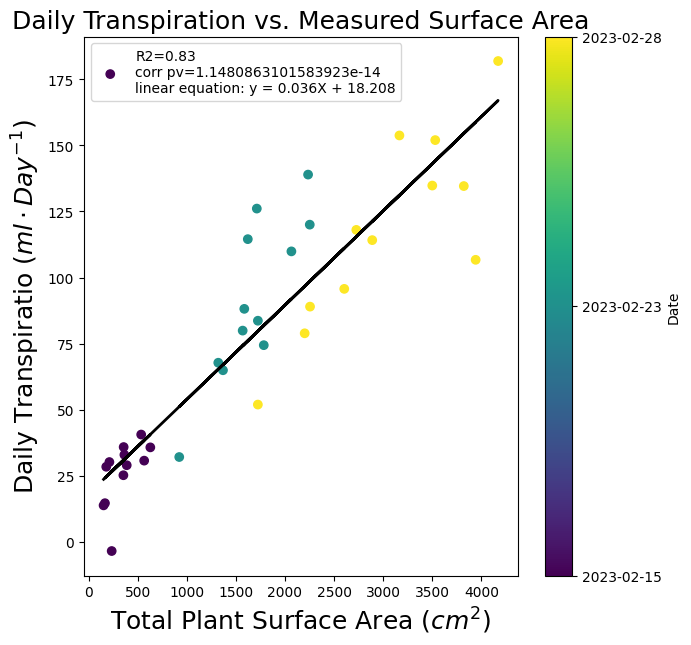

In [129]:
### plottinh the correlation

X = np.asarray(transpiration_growth_combined['calculated_area'])
Y = np.asarray(transpiration_growth_combined['transpiration_data'])
dates = pd.to_datetime(transpiration_growth_combined['date'])

### convert dates to integers for the labelling
date_labels = dates.dt.date
date_mapping = {date: i for i, date in enumerate(date_labels)}
categorical_dates = [date_mapping[date] for date in date_labels]

res = stats.pearsonr(X, Y)
r2 = round((res.statistic**2), 2)
pv = res.pvalue

regr = LinearRegression().fit(X.reshape(-1, 1), Y.reshape(-1, 1))
y_pred = regr.predict(X.reshape(-1, 1))

coef_ = round(regr.coef_[0][0], 3)
intercept_ = round(regr.intercept_[0], 3)
eqaution = f"y = {coef_}X + {intercept_}"

x_linear = np.linspace(X.min(), X.max(), 100)
y_linear = x_linear

plt.figure(figsize=(7, 7))

### color the dots based on converted dates
scatter = plt.scatter(X, Y, c=categorical_dates, cmap='viridis', label=f'R2={r2}\ncorr pv={pv}\nlinear equation: {eqaution}')
cbar = plt.colorbar(scatter, ticks=list(date_mapping.values()))
cbar.set_label('Date')
cbar.set_ticklabels(list(date_mapping.keys()))

plt.plot(X, y_pred, color="black", linewidth=2)
plt.title('Daily Transpiration vs. Measured Surface Area', fontsize=18)
plt.xlabel('Total Plant Surface Area ($cm^2$)', fontsize=18)
plt.ylabel('Daily Transpiratio ($ml\cdot{Day}^{-1}$)', fontsize=18)
plt.legend()
plt.show()

# Color distribution 
not included in the research, can be added to future research

In [133]:
dataset='samples/round_2/28.2.23/18/28.2.23_18_edited.txt'
dataset_path = os.path.join(working_directory, dataset)
point_cloud = np.loadtxt(dataset_path,delimiter=' ')
    

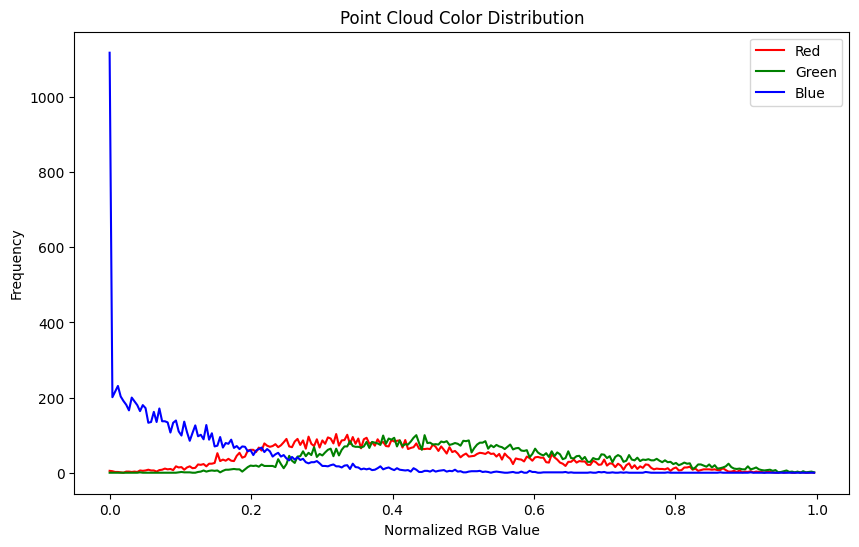

In [134]:
rgb_values = point_cloud[:, 3:6] 

### normalized RGB values in range [0, 1]
normalized_rgb = rgb_values / 255.0

### computr the color distribution
num_bins = 256
r_hist, r_bins = np.histogram(normalized_rgb[:, 0], bins=num_bins, range=(0, 1))
g_hist, g_bins = np.histogram(normalized_rgb[:, 1], bins=num_bins, range=(0, 1))
b_hist, b_bins = np.histogram(normalized_rgb[:, 2], bins=num_bins, range=(0, 1))


plt.figure(figsize=(10, 6))
plt.plot(r_bins[:-1], r_hist, color='red', label='Red')
plt.plot(g_bins[:-1], g_hist, color='green', label='Green')
plt.plot(b_bins[:-1], b_hist, color='blue', label='Blue')
plt.title('Point Cloud Color Distribution')
plt.xlabel('Normalized RGB Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

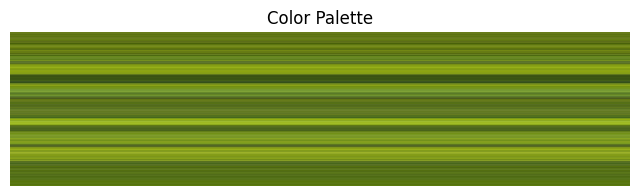

In [135]:
### another way of showing point cloud color distrubution 

palette = normalized_rgb.reshape(-1, 1, 3)
plt.figure(figsize=(8, 2))
plt.imshow(palette, aspect='auto')
plt.title('Color Palette')
plt.axis('off')
plt.show()